# Rappi Challenge

**Coded by:** Jorge Polanco Roque

## I. Settings: 

In [1]:
# Libraries
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.svm import SVC
import seaborn as sbn
import pandas as pd
import numpy as np
import warnings
import random
import copy
import re

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Setting a random seed
random.seed(123)

In [3]:
# Hidding warnings
warnings.filterwarnings('ignore')

In [4]:
# Loading input files
path = "C:/Users/jpolancoroque/Desktop/Job Applications/Rappi"

db = pd.read_csv(path+"/orders.csv", sep = ",")

## II. Feature Engineering:

In [5]:
# Original database
db.head(5)

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07T20:02:17Z,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07T20:13:16Z,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07T20:07:23Z,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07T20:15:19Z,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07T20:12:14Z,1


In [6]:
# Data type of each column
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           146987 non-null  int64  
 1   store_id           146987 non-null  int64  
 2   to_user_distance   146987 non-null  float64
 3   to_user_elevation  146987 non-null  float64
 4   total_earning      146987 non-null  int64  
 5   created_at         146987 non-null  object 
 6   taken              146987 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 7.9+ MB


1    135407
0     11580
Name: taken, dtype: int64


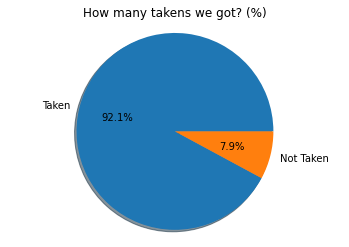

In [7]:
# How many takens we got?
print(db['taken'].value_counts())
# pie chart of workers
labels = ['Taken', 'Not Taken']
sizes = [db['taken'].value_counts()[1],
         db['taken'].value_counts()[0]
        ]
# print(sizes) # adds up to 1433, which is the total number of participants
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('How many takens we got? (%)')

plt.show()

In [8]:
# Configuration of data types
db["order_id"] = db["order_id"].astype('object')
db["store_id"] = db["store_id"].astype('object')
db["to_user_distance"] = round((db["to_user_distance"]*1000),2).astype('float64')
db["to_user_elevation"] = round((db["to_user_elevation"]),2).astype('float64')

In [9]:
# Renaming columns
db.rename(columns={'to_user_distance':'to_user_distance (mts)', 'to_user_elevation' : 'to_user_elevation (mts)'}, inplace=True)

In [10]:
# Triangulation between store and user considering the y and x axis (elevation and distance, respectively)
db["hypotenuse"] = ((db["to_user_distance (mts)"]**2)+(db["to_user_elevation (mts)"]**2))**(1/2)
db["hypotenuse"] = round(db["hypotenuse"],2).astype('float64')

In [11]:
# Regex changes
rex = r'T|Z'

datetime_db = []

for i in db["created_at"]:
    datetime_db.append(re.split(rex, i))

datetime_db = pd.DataFrame(datetime_db)
datetime_db.columns = ["Date","Time","0"]
datetime_db = datetime_db[["Date","Time"]]

In [12]:
# Substituting datetime feature
db = db.drop(["created_at"], axis = 1)
db[["Date","Time"]] = datetime_db[["Date","Time"]].values

In [13]:
# Date format
db["Date"] = pd.to_datetime(db["Date"], infer_datetime_format=True)

db["Date_Year"] = db["Date"].dt.year
db["Date_Month"] = db["Date"].dt.month
db["Date_Day"] = db["Date"].dt.day_name(locale = "English")
db["Date_MonthDay"] = db["Date"].dt.day

In [14]:
# One-Hot Encoding Day
months_db = pd.get_dummies(db["Date_Month"], prefix='Date_Month')
months_db = months_db.drop(["Date_Month_10"], axis = 1)

db[['Date_Month']] = months_db[['Date_Month_9']].values

In [15]:
# Because we only have September and October data, it could be convenient having a dummy variable
db.rename(columns={'Date_Month':'September'}, inplace=True)

In [16]:
# Creating Week-ends
col = 'Date_Day'
conditions = [ (db[col] == 'Friday') | (db[col] == "Saturday") | (db[col] == "Sunday") ]
choices = [ 1 ]

db["Date_Weekends"] = np.select(conditions, choices, default= 0)

db["Date_Weekends"].value_counts()

1    75816
0    71171
Name: Date_Weekends, dtype: int64

Saturday     2577
Friday       1882
Tuesday      1590
Thursday     1468
Sunday       1441
Monday       1325
Wednesday    1297
Name: Date_Day, dtype: int64


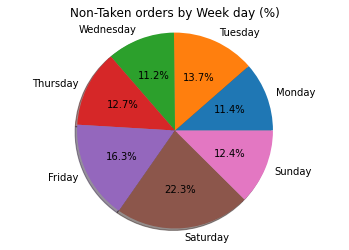

In [17]:
# Non-Taken orders by Week day
print(db['Date_Day'][db['taken'] == 0].value_counts())

# pie chart of workers
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sizes = [db['Date_Day'][db['taken'] == 0].value_counts()["Monday"],
         db['Date_Day'][db['taken'] == 0].value_counts()["Tuesday"],
         db['Date_Day'][db['taken'] == 0].value_counts()["Wednesday"],
         db['Date_Day'][db['taken'] == 0].value_counts()["Thursday"],
         db['Date_Day'][db['taken'] == 0].value_counts()["Friday"],
         db['Date_Day'][db['taken'] == 0].value_counts()["Saturday"],
         db['Date_Day'][db['taken'] == 0].value_counts()["Sunday"]
        ]
# print(sizes) # adds up to 1433, which is the total number of participants
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Non-Taken orders by Week day (%)')

plt.show()

In [18]:
# One-Hot Encoding Day
date_day_db = pd.get_dummies(db["Date_Day"], prefix='Date_Day')

db = db.drop(["Date_Day"], axis = 1)
db[['Date_Day_Friday', 'Date_Day_Monday', 'Date_Day_Saturday',
       'Date_Day_Sunday', 'Date_Day_Thursday', 'Date_Day_Tuesday','Date_Day_Wednesday']] = date_day_db.values

In [19]:
# Time format
db["Time_Hour"] = pd.to_datetime(db["Time"]).dt.hour

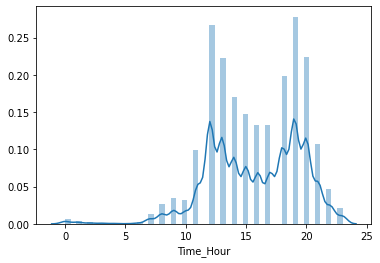

In [20]:
# Time_Hour Distribution
sbn.distplot(db["Time_Hour"])

In [21]:
# Creating a group of hours
col = 'Time_Hour'
conditions = [ db[col] <= 6, (db[col] > 6) & (db[col] <= 12), (db[col] > 12) & (db[col] <= 18), 
               (db[col] > 18) & (db[col] <= 23) ]
choices = [ "Early Morning", "Morning", "Afternoon", "Night" ]

db["Hour_Group"] = np.select(conditions, choices, default=np.nan)

db["Hour_Group"].value_counts()

Afternoon        67889
Night            45875
Morning          31929
Early Morning     1294
Name: Hour_Group, dtype: int64

In [22]:
# One-Hot Encoding Hour Group
hour_group_db = pd.get_dummies(db["Hour_Group"], prefix='Hour_Group')

db = db.drop(["Hour_Group"], axis = 1)
db[['Hour_Group_Afternoon', 'Hour_Group_Early Morning',
       'Hour_Group_Morning', 'Hour_Group_Night']] = hour_group_db.values

In [23]:
# Data type of each feature
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  146987 non-null  object        
 1   store_id                  146987 non-null  object        
 2   to_user_distance (mts)    146987 non-null  float64       
 3   to_user_elevation (mts)   146987 non-null  float64       
 4   total_earning             146987 non-null  int64         
 5   taken                     146987 non-null  int64         
 6   hypotenuse                146987 non-null  float64       
 7   Date                      146987 non-null  datetime64[ns]
 8   Time                      146987 non-null  object        
 9   Date_Year                 146987 non-null  int64         
 10  September                 146987 non-null  int64         
 11  Date_MonthDay             146987 non-null  int64         
 12  Da

In [24]:
# Final database
db.iloc[:,10:].head(3)

,September,Date_MonthDay,Date_Weekends,Date_Day_Friday,Date_Day_Monday,Date_Day_Saturday,Date_Day_Sunday,Date_Day_Thursday,Date_Day_Tuesday,Date_Day_Wednesday,Time_Hour,Hour_Group_Afternoon,Hour_Group_Early Morning,Hour_Group_Morning,Hour_Group_Night
0,1,7,0,0,0,0,0,1,0,0,20,0,0,0,1
1,1,7,0,0,0,0,0,1,0,0,20,0,0,0,1
2,1,7,0,0,0,0,0,1,0,0,20,0,0,0,1


In [25]:
# Column list of the database
db.columns

Index(['order_id', 'store_id', 'to_user_distance (mts)',
       'to_user_elevation (mts)', 'total_earning', 'taken', 'hypotenuse',
       'Date', 'Time', 'Date_Year', 'September', 'Date_MonthDay',
       'Date_Weekends', 'Date_Day_Friday', 'Date_Day_Monday',
       'Date_Day_Saturday', 'Date_Day_Sunday', 'Date_Day_Thursday',
       'Date_Day_Tuesday', 'Date_Day_Wednesday', 'Time_Hour',
       'Hour_Group_Afternoon', 'Hour_Group_Early Morning',
       'Hour_Group_Morning', 'Hour_Group_Night'],
      dtype='object')

In [26]:
# Let's create a copy just in case
db_original = copy.copy(db)

In [27]:
# So this is the original database after some changes
db_original.head()

,order_id,store_id,to_user_distance (mts),to_user_elevation (mts),total_earning,taken,hypotenuse,Date,Time,Date_Year,...,Date_Day_Saturday,Date_Day_Sunday,Date_Day_Thursday,Date_Day_Tuesday,Date_Day_Wednesday,Time_Hour,Hour_Group_Afternoon,Hour_Group_Early Morning,Hour_Group_Morning,Hour_Group_Night
0,14364873,30000009,2478.10,-72.72,4200,0,2479.17,2017-09-07,20:02:17,2017,...,0,0,1,0,0,20,0,0,0,1
1,14370123,30000058,451.71,37.75,4200,0,453.28,2017-09-07,20:13:16,2017,...,0,0,1,0,0,20,0,0,0,1
2,14368534,900003684,2026.07,207.19,4000,0,2036.64,2017-09-07,20:07:23,2017,...,0,0,1,0,0,20,0,0,0,1
3,14370258,900014452,2671.43,1.72,4400,1,2671.43,2017-09-07,20:15:19,2017,...,0,0,1,0,0,20,0,0,0,1
4,14369923,900014085,965.50,117.43,3450,1,972.62,2017-09-07,20:12:14,2017,...,0,0,1,0,0,20,0,0,0,1


In order to eliminate False Positives, I will drop all the outliers in hypotenuse, which represents total distance.

In [28]:
# Excluding outliers in the distance feature
db_no_outliers = db[db['hypotenuse'].between(db['hypotenuse'].quantile(.05), db['hypotenuse'].quantile(.95)) == True]

In [29]:
# Defining scalar
scaler = StandardScaler()

db_scaled = pd.DataFrame(scaler.fit_transform(db_no_outliers[['to_user_distance (mts)',
                                                  'to_user_elevation (mts)', 'total_earning', 'hypotenuse']]))

db_scaled.columns = ['to_user_distance (mts)','to_user_elevation (mts)', 'total_earning', 'hypotenuse']


db_no_outliers[['to_user_distance (mts)','to_user_elevation (mts)', 'total_earning', 'hypotenuse']] = db_scaled[['to_user_distance (mts)','to_user_elevation (mts)', 'total_earning', 'hypotenuse']].values

In [30]:
# Select the most important variables
X = db_no_outliers[['total_earning', 'hypotenuse','September','Date_Weekends', 'Date_Day_Friday',
        'Date_Day_Saturday', 'Date_Day_Sunday','Date_Day_Thursday','Date_Day_Tuesday', 
        'Date_Day_Wednesday','Hour_Group_Afternoon','Hour_Group_Morning', 'Hour_Group_Night',
        'to_user_distance (mts)','to_user_elevation (mts)', 'Date_MonthDay', 'Date_Day_Monday',
        'Time_Hour', 'Hour_Group_Early Morning']]

y = db_no_outliers[['taken']]

In [31]:
# Splitting my database to model it
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, stratify=y)

In [32]:
#from sklearn.model_selection import StratifiedShuffleSplit

#sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

#for train_index, test_index in sss.split(X, y):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## III. Modeling:

Steps:
* Hyperparameter Tunning
* Model Selection

**a) Logistic Regression:**

In [33]:
# Hyperparameter Optimization
log_reg = LogisticRegression()
param_grid1 = [{'penalty' : ['l2'],
               'C' : np.logspace(-4,4,5),
               'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }]


clf_log_reg = GridSearchCV(log_reg, param_grid = param_grid1, cv = 5, verbose = True, n_jobs = 8, scoring ='roc_auc')

In [34]:
# GridSearchCV help us to run at once many combinations of hyperparameters
#best_clf_log_reg = clf_log_reg.fit(X_train, y_train)

In [35]:
# The following is the result of the best model considering the ROC AUC
#print(best_clf_log_reg.best_estimator_)

In [36]:
# The best model considering the set of options I tested in the previous lines
log_reg2 = LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [37]:
# Training the model
best_clf_log_reg = log_reg2.fit(X, y)

In [38]:
# Run the predictions using the test set
grid_predictions_log_reg = log_reg2.predict(X_test)

In [39]:
# The confusion matrix will help us know how good is the model in classifying the target variable
print(confusion_matrix(y_test,grid_predictions_log_reg))

[[    0  3130]
 [    0 36557]]


In [40]:
# Accuracy metrics
print(classification_report(y_test,grid_predictions_log_reg))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3130
          1       0.92      1.00      0.96     36557

avg / total       0.85      0.92      0.88     39687



In [41]:
# This last test will tell us which model is the best one
print('AUC:', round(cross_val_score(log_reg2, X_test, y_test, cv=5, scoring='roc_auc').mean(),2)*100, 'Accuracy:', 
      round(cross_val_score(log_reg2, X_test, y_test, cv=5, scoring='accuracy').mean(),2)*100)

AUC: 65.0 Accuracy: 92.0


The coefficients of this model can give us an idea of the importance of each one of the variables. According to the Log Regression, the most important variables are: Hour_Group and Date_Day ones.

In [42]:
# Coefficients
log_reg_coef = pd.DataFrame(best_clf_log_reg.coef_, columns = list(X.columns)).transpose()
log_reg_coef = log_reg_coef.sort_values(by = [0], ascending=False)
log_reg_coef.columns = ['Coef']
log_reg_coef

,Coef
Hour_Group_Afternoon,0.989447
Hour_Group_Morning,0.867601
Hour_Group_Night,0.860448
Date_Day_Wednesday,0.597842
Date_Day_Sunday,0.505474
Date_Day_Tuesday,0.366511
Date_Day_Thursday,0.337611
Date_Weekends,0.323323
Date_Day_Monday,0.320717
total_earning,0.268286


**b) Random Forest:**

In [43]:
# Hyperparameter Optimization
rfc = RandomForestClassifier()
param_grid2 = [{ 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']}]

clf_rfc = GridSearchCV(rfc, param_grid = param_grid2, cv = 5, verbose = True, n_jobs = 8, scoring ='roc_auc')

In [44]:
#best_clf_rfc = clf_rfc.fit(X, y)

In [45]:
#print(best_clf_rfc.best_estimator_)

In [46]:
rfc2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
best_clf_rfc = rfc2.fit(X, y)

In [48]:
grid_predictions_rfc = best_clf_rfc.predict(X_test)

In [49]:
print(confusion_matrix(y_test,grid_predictions_rfc))

[[    1  3129]
 [    0 36557]]


In [50]:
print(classification_report(y_test,grid_predictions_rfc))

             precision    recall  f1-score   support

          0       1.00      0.00      0.00      3130
          1       0.92      1.00      0.96     36557

avg / total       0.93      0.92      0.88     39687



In [51]:
print('AUC:', round(cross_val_score(rfc2, X_test, y_test, cv=5, scoring='roc_auc').mean(),2)*100, 'Accuracy:', 
      round(cross_val_score(rfc2, X_test, y_test, cv=5, scoring='accuracy').mean(),2)*100)

AUC: 70.0 Accuracy: 92.0


**c) Gradient Boosting Classifier:**

In [52]:
# Hyperparameter Optimization
gbc = GradientBoostingClassifier()
param_grid3 = [{
    "loss":["deviance"],
    "learning_rate": [0.01, 0.1],
    "min_samples_split": np.linspace(0.1, 0.5, 6),
    "min_samples_leaf": np.linspace(0.1, 0.5, 6),
    "max_depth":[3,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 1.0],
    "n_estimators":[10]
    }]

clf_gbc = GridSearchCV(gbc, param_grid = param_grid3, cv = 5, verbose = True, n_jobs = 8, scoring ='roc_auc')

In [53]:
#best_clf_gbc = clf_gbc.fit(X_train, y_train)

In [54]:
#print(best_clf_gbc.best_estimator_)

In [55]:
gbc2 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.1, min_samples_split=0.1,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [56]:
best_clf_gbc = gbc2.fit(X, y)

In [57]:
grid_predictions_gbc = best_clf_gbc.predict(X_test)

In [58]:
print(confusion_matrix(y_test,grid_predictions_gbc))

[[    0  3130]
 [    0 36557]]


In [59]:
print(classification_report(y_test,grid_predictions_gbc))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3130
          1       0.92      1.00      0.96     36557

avg / total       0.85      0.92      0.88     39687



In [60]:
print('AUC:', round(cross_val_score(gbc2, X_test, y_test, cv=5, scoring='roc_auc').mean(),2)*100, 'Accuracy:', 
      round(cross_val_score(gbc2, X_test, y_test, cv=5, scoring='accuracy').mean(),2)*100)

AUC: 66.0 Accuracy: 92.0


**d) Ada Boost Classifier:**

In [61]:
# Hyperparameter Optimization
abc = AdaBoostClassifier()
best_clf_abc = abc.fit(X_train, y_train)

In [62]:
grid_predictions_abc = best_clf_abc.predict(X_test)

In [63]:
print(confusion_matrix(y_test,grid_predictions_abc))

[[    1  3129]
 [    5 36552]]


In [64]:
print(classification_report(y_test,grid_predictions_abc))

             precision    recall  f1-score   support

          0       0.17      0.00      0.00      3130
          1       0.92      1.00      0.96     36557

avg / total       0.86      0.92      0.88     39687



In [65]:
print('AUC:', round(cross_val_score(best_clf_abc, X_test, y_test, cv=5, scoring='roc_auc').mean(),2)*100, 'Accuracy:', 
      round(cross_val_score(best_clf_abc, X_test, y_test, cv=5, scoring='accuracy').mean(),2)*100)

AUC: 70.0 Accuracy: 92.0


**e) Neural Network:** The Winner!

Considering several accuracy analysis, it seems that this model presents the best performance in terms of ROC AUC. Moreover, unlike other models, this one is presenting a better performance identifying both 0s and 1s.

In [66]:
# Hyperparameter Optimization
nn = MLPClassifier()
param_grid5 = [{
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}]

clf_nn = GridSearchCV(nn, param_grid = param_grid5, cv = 5, verbose = True, n_jobs = 8, scoring ='roc_auc')

In [67]:
#best_clf_nn = clf_nn.fit(X, y)

In [68]:
#print(best_clf_nn.best_estimator_)

In [69]:
nn2 = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [70]:
best_clf_nn = nn2.fit(X, y)

In [71]:
grid_predictions_nn = best_clf_nn.predict(X_test)

In [72]:
print(confusion_matrix(y_test,grid_predictions_nn))

[[  216  2914]
 [   96 36461]]


In [73]:
print(classification_report(y_test,grid_predictions_nn))

             precision    recall  f1-score   support

          0       0.69      0.07      0.13      3130
          1       0.93      1.00      0.96     36557

avg / total       0.91      0.92      0.89     39687



In [74]:
print('AUC:', round(cross_val_score(nn2, X_test, y_test, cv=10, scoring='roc_auc').mean(),2)*100, 'Accuracy:', 
      round(cross_val_score(nn2, X_test, y_test, cv=10, scoring='accuracy').mean(),2)*100)

AUC: 70.0 Accuracy: 92.0
